# Tute 2 - Regualarised Regression

In [1]:
# import all the important packages

# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes (exactly the same as tables in Matlab)
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

In [2]:
# loading in the combined data from the previous tute
combined_filtered = pd.read_csv('./tute2_data/combined.csv')
# make sure the Date column is interpreted correctly as a datetime object
combined_filtered.Date = pd.to_datetime(combined_filtered.Date, format='%Y-%m-%d')
print(combined_filtered.head())

   Unnamed: 0  Rainfall amount (millimetres)       Date  \
0         169                            0.0 2014-06-19   
1         170                            5.8 2014-06-20   
2         171                            0.0 2014-06-21   
3         172                            5.2 2014-06-22   
4         173                            0.2 2014-06-23   

   Maximum temperature (Degree C)  Daily global solar exposure (MJ/m*m)  \
0                            20.3                                   8.0   
1                            22.5                                   9.1   
2                            25.6                                  12.9   
3                            24.2                                  13.0   
4                            24.1                                  13.6   

   Story Bridge West Pedestrian Inbound  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                     

In [3]:
train = combined_filtered[combined_filtered.Date < datetime(year=2017, month=1, day=1)]
val = combined_filtered[((combined_filtered.Date >= datetime(year=2017, month=1, day=1)) &
                        (combined_filtered.Date < datetime(year=2018, month=1, day=1)))]
test = combined_filtered[((combined_filtered.Date >= datetime(year=2018, month=1, day=1)) &
                          (combined_filtered.Date < datetime(year=2019, month=1, day=1)))]
print('num train = {}'.format(train.shape[0]))
print('val train = {}'.format(val.shape[0]))
print('test train = {}'.format(test.shape[0]))

num train = 888
val train = 276
test train = 258


#Q1 - Overfitting Linear Regression

In the week 1 practical, you developed a model to predict cyclist counts at a single counter. Using the same data and starting from the initial model before terms were remove, overcomplicate it such that it overfits to the training data. The easiest way to do this is by including a large number of higher order (i.e. interaction, quadratic and higher order polynomial) terms. 
Verify that the model has overfit through evaluating on the validation and testing datasets, and compare it’s performance to the simple model that you started with.

Linear Model RMSE = 623.3791739360698
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     113.1
Date:                Fri, 06 Mar 2020   Prob (F-statistic):          4.59e-118
Time:                        11:37:47   Log-Likelihood:                -6899.6
No. Observations:                 888   AIC:                         1.382e+04
Df Residuals:                     880   BIC:                         1.385e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7

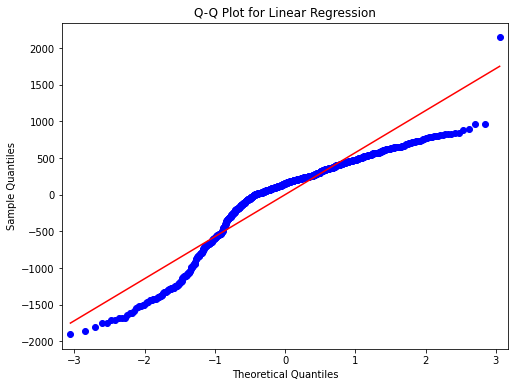

In [4]:
# lets start with the model we had from last week
# now perform linear regression using Ordinary Least Squares
# want to use all weather data from the BOM
X_bom = ['Rainfall amount (millimetres)',
         'Daily global solar exposure (MJ/m*m)',
         'Maximum temperature (Degree C)']
# want to use all variables cyclist inbound variables
X_bcc = [x for x in train.columns.values if 'Cyclists Inbound' in x]
# remove the response variable from here
X_bcc.remove('Bicentennial Bikeway Cyclists Inbound')
# combine this list of variables together by just extending the
# BOM data with the BCC data
X_variables_linear = X_bom + X_bcc
Y_variable = 'Bicentennial Bikeway Cyclists Inbound'
Y_train = np.array(train[Y_variable], dtype=np.float64)
X_train = np.array(train[X_variables_linear], dtype=np.float64)
# want to add a constant to the model (the y-axis intercept)
X_train_constant = sm.add_constant(X_train)
# also creating validation data
Y_val = np.array(val[Y_variable], dtype=np.float64)
X_val = np.array(val[X_variables_linear], dtype=np.float64)
X_val_constant = sm.add_constant(X_val)
# will create our test data as well, we will need it later on
Y_test = np.array(test[Y_variable], dtype=np.float64)
X_test = np.array(test[X_variables_linear], dtype=np.float64)
# create the linear model
model = sm.OLS(Y_train, X_train_constant)
# fit the model without any regularisation
model_1_fit = model.fit()
pred = model_1_fit.predict(X_val_constant)
print('Linear Model RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_1_fit.predict(X_val_constant)))))
print(model_1_fit.summary())
print(model_1_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_1_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()


Want to add some quadratic terms to our model.

In [5]:
def x2fx_quadratic(row, arg_name):
  """Will create a quadratic version of our variable of interest
  
  Is intended to be applied to a Pandas dataframe using the `apply()` method.

  Similar to the `x2fx()` function in Matlab.

  Args:
    row (pd.Series):
      row in the original pandas dataframe we are applying the function to
    args_name (str):
      column name to to which we are indexing from the original dataframe
    
  Returns:
    A pandas Series which will contain row[arg_name] ^ 2
  """
  return np.square(row[arg_name])


def x2fx(x, model='quadratic'):
  from itertools import combinations as comb
  linear = np.c_[np.ones(x.shape[0]), x]
  if model == 'linear':
    return linear
  if model == 'purequadratic':
    return np.c_[linear, x**2]

  interaction = np.vstack([x[:,i]*x[:,j] for i, j in
                           comb(range(x.shape[1]), 2)]).T
  print(interaction.shape)
  if model == 'interaction':
    return np.c_[linear, interaction]
  if model == 'quadratic':
    return np.c_[linear, interaction, x**2]
  

In [14]:
print(X_train.shape)
X_train_complex = x2fx(X_train)
X_val_complex = x2fx(X_val)
X_test_complex = x2fx(X_test)
print(X_train_complex.shape)
print(X_val_complex.shape)

(888, 7)
(888, 21)
(276, 21)
(258, 21)
(888, 36)
(276, 36)


In [15]:
print(pd.__version__)

1.0.1


Model 2: Quadratic Variables RMSE = 788.1013862359443
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     29.20
Date:                Fri, 06 Mar 2020   Prob (F-statistic):          2.72e-121
Time:                        12:22:09   Log-Likelihood:                -6834.5
No. Observations:                 888   AIC:                         1.374e+04
Df Residuals:                     852   BIC:                         1.391e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

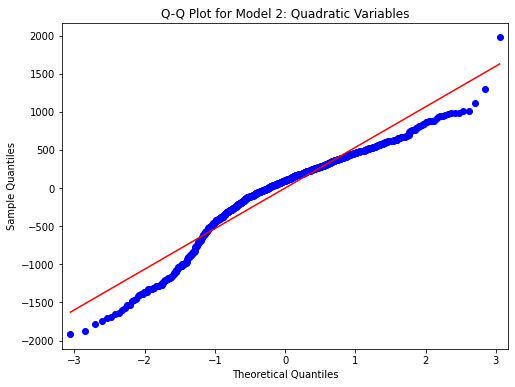

In [18]:
model = sm.OLS(Y_train, X_train_complex)
# fit the model without any regularisation
model_2_fit = model.fit()
pred = model_2_fit.predict(X_val_complex)
print('Model 2: Quadratic Variables RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_2_fit.predict(X_val_complex)))))
print(model_2_fit.summary())
print(model_2_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_2_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Model 2: Quadratic Variables')
plt.show()


## Standardise data set 

In [8]:
def standardise(data):
  """ Standardise/Normalise data to have zero mean and unit variance

  Args:
    data (np.array):
      data we want to standardise (usually covariates)

    Returns:
      Standardised data, mean of data, standard deviation of data
  """
  mu = np.mean(data)
  sigma = np.std(data)
  scaled = (data - mu) / sigma
  return scaled, mu, sigma

Now will normalise the training data set, and will use mean and standard deviation of the training data to standardisse the validation and test data

In [9]:
X_train_std, mu_train, sigma_train = standardise(X_train)
Y_train_std, mu_test, sigma_test = standardise(Y_train)
X_val_std = (X_val - mu_train)/sigma_train
Y_val_std = (Y_val - mu_test)/sigma_test
X_test_std = (X_test - mu_train)/sigma_train
Y_test_std = (Y_test - mu_test)/sigma_test

X_train_complex_std, mu_train_complex, sigma_train_complex = standardise(X_train_complex)
X_val_complex_std = (X_val_complex - mu_train_complex)/sigma_train_complex
X_test_complex_std = (X_test_complex - mu_train_complex)/sigma_train_complex

Model 3: L1 RMSE = 620.2903612480512
[ -1.41911608 -15.84494336  -4.83940332   7.48862925   1.9102867
   1.16268124  -0.12017558]


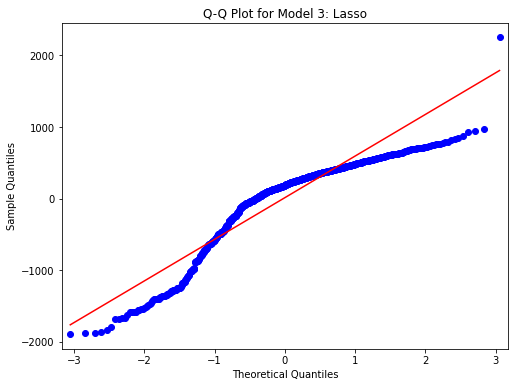

In [10]:
# quick test with normalised regression
model_3 = sm.OLS(Y_train, X_train)

model_3_fit = model_3.fit_regularized(alpha=1.0, L1_wt=1)
# to get L1 regression, need to set the L1_wt flag to 1 in the fit_regularzed method
pred = model_3_fit.predict(X_val)
print('Model 3: L1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_3_fit.predict(X_val)))))
print(model_3_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_2_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Model 3: Lasso')
plt.show()


Model 3: L2 RMSE = 614.3121609428285
[ -1.47047376 -12.88322479  -5.37320333   7.18088458   1.91603196
   1.15566736  -0.23142138]


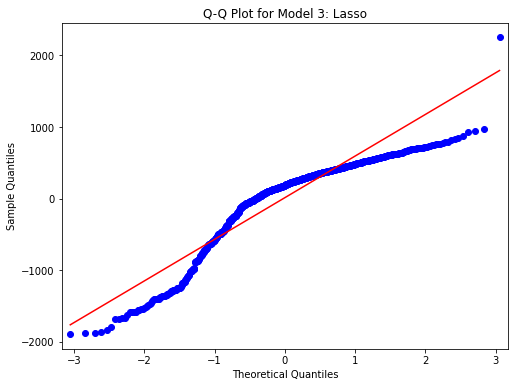

In [11]:
# L2 Regression
model_3_fit = model_3.fit_regularized(alpha=1.0, L1_wt=0)
# to get L1 regression, need to set the L1_wt flag to 1 in the fit_regularzed method
pred = model_3_fit.predict(X_val)
print('Model 3: L2 RMSE = {}'.format(
  np.sqrt(mean_squared_error(Y_val, model_3_fit.predict(X_val)))))
print(model_3_fit.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model_2_fit.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Model 3: Lasso')
plt.show()

In [12]:
def rSquared(actual, predicted):
  sst = np.var(actual) * actual.size;
  sse = np.sum((actual - predicted)**2);
  r2 = 1 - sse/sst;
  return r2

In [13]:
def adj_r2(actual, predicted, n, p):
  sst = np.var(actual)* np.size(actual)
  sse = np.sum((actual - predicted)**2)
  adjr2 = 1 - ((n - 1)/(n - p - 1))*(sse/sst);
  return adjr2